## 0. License and Disclaimer

Copyright 2024 DeepMind Technologies Limited

Except as set out above in the "Images ResNet"
and "Time series ResNet" sections, all software is licensed under the Apache License, Version 2.0 (Apache 2.0); you may not use this file except in compliance with the Apache 2.0 license. You may obtain a copy of the Apache 2.0 license at:

https://www.apache.org/licenses/LICENSE-2.0

All other materials are licensed under the Creative Commons Attribution 4.0 International License (CC-BY). You may obtain a copy of the CC-BY license at:

https://creativecommons.org/licenses/by/4.0/legalcode

Unless required by applicable law or agreed to in writing, all software and materials distributed here under the Apache 2.0 or CC-BY licenses are distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the licenses for the specific language governing permissions and limitations under those licenses.

This is not an official Google product.


## 1. Intro

### Welcome to the tutorial for the [Inundata: Mapping Floods in South Africa Challenge](https://zindi.africa/competitions/inundata-mapping-floods-in-south-africa)!

In this notebook, we'll be taking you through an explanation of the challenge, dataset, and an example approach for building a model that can identify if a flood took place in a region and when.

The goal of this challenge is to develop a machine learning model capable of identifying the specific day in which an urban flash flood occurred. This will then help to build a historical catalogue of flood events.

<a name="Dataset"></a>
## 2. Dataset overview

For this challenge we have gathered data for different locations in South Africa, each location correspond to an event_id.

For each event_id the dataset provided consists of:
 ,

*   Rainfall values stored in `train.csv` file
*   Satellite images obtained by Sentinel-2 for five different wavelengths, which correspond to different colours, stored in `composite_images.npz`.
* Slope images obtained from NASA topography mission (SRTM) stored in `composite_images.npz`.



`test.csv` contains the test set, consisting of 181041 time steps to label as flooded or not flooded, corresponding to 248 events. Note that as output we ask you to return the probability of that event being a flooded event.



<a name="Exploration"></a>
## 3. Data exploration

Next, we can load the train and test datasets and look at some of the images.

First let's intall a set of tools and import some packages.

In [1]:
# !pip install -q ml-collections scikit-image flax jax jaxlib
!pip install -q scikit-image flax jax jaxlib

In [2]:
# @title Imports

import collections
from collections.abc import Callable, Sequence
from concurrent import futures
from datetime import datetime
from functools import partial
import math
import multiprocessing
import os
from typing import Any

import flax
from flax import linen as nn
from flax.metrics import tensorboard
from flax.training import train_state
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import optax
import pandas as pd
from PIL import Image
import scipy
import seaborn as sns
import skimage as ski
from tqdm.notebook import tqdm

# Install missing package
%pip install google-colab
%pip install tensorflow_datasets

import tensorflow_datasets as tfds

try:
    from google.colab import drive
    drive.mount('/content/drive')
    from google.colab import widgets
except ModuleNotFoundError:
    print("google.colab module not found. Running outside of Google Colab.")


c:\Users\CraigParker\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement google-colab (from versions: none)
ERROR: No matching distribution found for google-colab


Note: you may need to restart the kernel to use updated packages.
google.colab module not found. Running outside of Google Colab.


You can download the data from the Zindi competition link and store in your drive folder. Then, upload it to this colab or add a shortcut to your Drive folder.

In [3]:
# Replace this path with your path
BASE_PATH = r'C:\Users\CraigParker\OneDrive - Wits Health Consortium\PHR PC\Downloads\Joburg\Zindi_comp'  # Since files are directly in the Zindi_comp folder

### Load precipitation data


Load the precipitation training and test sets.

We also create columns to identify events, both by ID (`event_id`) and numerical index (`event_idx`). An event represents a particular location for which precipitation was measured.

Lastly, we generate a numerical index of time steps within each event (`event_t`)

In [4]:
train_path = os.path.join(BASE_PATH, 'Train.csv')
test_path = os.path.join(BASE_PATH, 'Test.csv')

if not os.path.exists(train_path):
	raise FileNotFoundError(f"Train.csv not found in {BASE_PATH}")
if not os.path.exists(test_path):
	raise FileNotFoundError(f"Test.csv not found in {BASE_PATH}")

data = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

data['event_id'] = data['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
data['event_idx'] = data.groupby('event_id', sort=False).ngroup()
data_test['event_id'] = data_test['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
data_test['event_idx'] = data_test.groupby('event_id', sort=False).ngroup()

data['event_t'] = data.groupby('event_id').cumcount()
data_test['event_t'] = data_test.groupby('event_id').cumcount()

print(data.head())
print(data_test.head())

          event_id  precipitation  label  event_idx  event_t
0  id_spictby0jfsb       0.000000      0          0        0
1  id_spictby0jfsb       0.095438      0          0        1
2  id_spictby0jfsb       1.949560      0          0        2
3  id_spictby0jfsb       3.232160      0          0        3
4  id_spictby0jfsb       0.000000      0          0        4
          event_id  precipitation  event_idx  event_t
0  id_j7b6sokflo4k        0.00000          0        0
1  id_j7b6sokflo4k        3.01864          0        1
2  id_j7b6sokflo4k        0.00000          0        2
3  id_j7b6sokflo4k       16.61520          0        3
4  id_j7b6sokflo4k        2.56706          0        4


Each event contains 730 days of precipitation measurements. Somewhere in these 730 days per location/event ID  there could be a flood. Due to the sparsity of identified floods we have created an imbalanced dataset where there are some "events" or "locations" that do not have a flood in any of the 730 days.


Check that indeed an event_id has 730 datapoints.

In [5]:
len(data[data.event_id == 'id_p8f40663jj3g'])

730

### Load image data

Now, we load the images (includes both training and test sets).

In [6]:
images_path = os.path.join(BASE_PATH, 'composite_images.npz')
images = np.load(images_path)
print(images)
print('The folder contains', len(images), 'images, both for train and test.')
print('There are', len(data['event_id'].unique()), 'train event ids and', len(data_test['event_id'].unique()), 'test event ids.')

NpzFile 'C:\\Users\\CraigParker\\OneDrive - Wits Health Consortium\\PHR PC\\Downloads\\Joburg\\Zindi_comp\\composite_images.npz' with keys: id_rhg5w8vmv3ny, id_rua8ey2jczl0, id_073l04ir88sn, id_wmkfqw7iwjmu, id_heri806er7xw...
The folder contains 898 images, both for train and test.
There are 674 train event ids and 224 test event ids.


The images are annual cloud-free composite images from [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) satellite imagery. They are of size 128x128 and contain the following 6 channels:
* Sentinel-2 B2 (Blue)
* Sentinel-2 B3 (Green)
* Sentinel-2 B4 (Red)
* Sentinel-2 B8 (NIR)
* Sentinel-2 B11 (SWIR)
* Slope (derived from NASA SRTM)

In [7]:
# Image metadata constants

# 5 bands and the slope of each image
BAND_NAMES =  ('B2', 'B3', 'B4', 'B8', 'B11', 'slope')
# Image shape
H, W, NUM_CHANNELS = IMG_DIM = (128, 128, len(BAND_NAMES))

You can visualize each of the bands of a given event_id

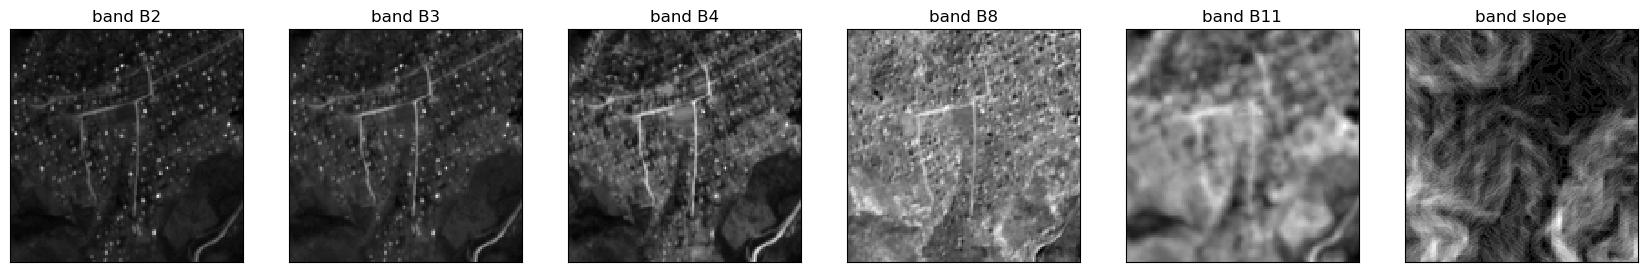

In [8]:
event_id = 'id_rhg5w8vmv3ny'

num_cols = len(BAND_NAMES)
_, axes = plt.subplots(
    ncols=num_cols,
    figsize=(num_cols * 3.5, 3.5),
    facecolor='white',
)

for band_idx in range(num_cols):
  img = images[event_id][..., band_idx]
  axes[band_idx].imshow(img, cmap='gray', interpolation='nearest')
  axes[band_idx].set_title(f'band {BAND_NAMES[band_idx]}')
  axes[band_idx].get_xaxis().set_visible(False)
  axes[band_idx].get_yaxis().set_visible(False)

### Construct splits and apply preprocessing

You can preprocess the image data to make it easier for the neural network model to process. We (approximately) normalize the image bands to make their mean near 0 and their standard deviation near 1, and we decode the slope data (which has been discretized as a 16-bit unsigned int) to radians.

In [9]:
sample_image = next(iter(images.values()))
assert sample_image.shape == IMG_DIM
assert sample_image.dtype == np.uint16
_MAX_INT = np.iinfo(np.uint16).max

def decode_slope(x: np.ndarray) -> np.ndarray:
  # Convert 16-bit discretized slope to float32 radians
  return (x / _MAX_INT * (math.pi / 2.0)).astype(np.float32)

def normalize(x: np.ndarray, mean: int, std: int) -> np.ndarray:
  return (x - mean) / std

rough_S2_normalize = partial(normalize, mean=1250, std=500)

def preprocess_image(x: np.ndarray) -> np.ndarray:
  return np.concatenate([
      rough_S2_normalize(x[..., :-1].astype(np.float32)),
      decode_slope(x[..., -1:]),
  ], axis=-1, dtype=np.float32)


You can create a validation-train split and use the validation set to choose your hyperparameters. Here we take 10% of the original training set as validation set.

In [10]:
rng = np.random.default_rng(seed=0xf100d)

event_ids = data['event_id'].unique()
new_split = pd.Series(
    data=np.random.choice(['train', 'valid'], size=len(event_ids), p=[0.9, 0.1]),
    index=event_ids,
    name='split',
)
data_new = data.join(new_split, on='event_id')

train_df = data_new[(data_new['split'] == 'train')]
train_timeseries = train_df.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()
train_labels = train_df.pivot(index='event_id', columns='event_t', values='label').to_numpy()

valid_df = data_new[data_new['split'] == 'valid']
valid_timeseries = valid_df.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()
valid_labels = valid_df.pivot(index='event_id', columns='event_t', values='label').to_numpy()

# For the test set there are no labels
test_timeseries = data_test.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()

event_splits = data_new.groupby('event_id')['split'].first()

Store the images in separated sets for validation training and test sets.

In [19]:
train_images = []
valid_images = []
test_images = []

for event_id in tqdm(event_splits.index):
  img = preprocess_image(images[event_id])
  if event_splits[event_id] == 'train':
    train_images.append(img)
  else:
    valid_images.append(img)

for event_id in tqdm(data_test['event_id'].unique()):
  img = preprocess_image(images[event_id])
  test_images.append(img)

train_images = np.stack(train_images, axis=0)
valid_images = np.stack(valid_images, axis=0)
test_images = np.stack(test_images, axis=0)

  0%|          | 0/674 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

Check that the sizes make sense.

In [20]:
print(f'{train_timeseries.shape=}')
print(f'    {train_images.shape=}')
print(f'    {train_labels.shape=}')

train_timeseries.shape=(606, 730)
    train_images.shape=(606, 128, 128, 6)
    train_labels.shape=(606, 730)


In [21]:
print(f'{valid_timeseries.shape=}')
print(f'    {valid_images.shape=}')
print(f'    {valid_labels.shape=}')

valid_timeseries.shape=(68, 730)
    valid_images.shape=(68, 128, 128, 6)
    valid_labels.shape=(68, 730)


In [22]:
print(f'{test_timeseries.shape=}')
print(f'    {test_images.shape=}')


test_timeseries.shape=(224, 730)
    test_images.shape=(224, 128, 128, 6)


# Training a model

This is a multimodal task, as you have two different types of inputs: 1D vectors corresponding to precipitation and 2D matrices corresponding to satellite images.

To be able to use the two input modalities, we propose here to run two different models on each type of input to obtain as output an embedding for each. Then, the two embeddings are concatenated to run a final dense layer which outputs a single value. This value is then passed to the loss function that uses a sigmoid binary cross entropy, suitable for a classification task with two classes: flooded true or flooded false.


As mentioned, we are using binary cross entropy loss, you can read more about it here: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

We use JAX and Flax to implement sample neural network models. Read more about these libraries here https://flax-linen.readthedocs.io/en/latest/guides/index.html.


These are just some examples, feel free to implement better models and tune the hyperparameters!

## Images ResNet

Copyright 2024 The Flax Authors, licensed under the Apache License, Version 2.0 (Apache 2.0) available at https://www.apache.org/licenses/LICENSE-2.0. Code has been modified from https://github.com/google/flax/blob/main/examples/imagenet/models.py

For the images, we use a ResNet model, which was originally introduced in https://arxiv.org/abs/1512.03385

In [23]:
"""Flax implementation of ResNet V1.5, without output head to return embedding."""
ModuleDef = Any


class ResNetBlock(nn.Module):
  """ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(
      self,
      x,
  ):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(
          self.filters, (1, 1), self.strides, name='conv_proj'
      )(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)


class ResNet(nn.Module):
  """ResNetV1.5."""

  stage_sizes: Sequence[int]
  block_cls: ModuleDef
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu
  conv: ModuleDef = nn.Conv

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    conv = partial(self.conv, use_bias=False, dtype=self.dtype)
    norm = partial(
        nn.BatchNorm,
        use_running_average=not is_training,
        momentum=0.9,
        epsilon=1e-5,
        dtype=self.dtype,
    )

    x = conv(
        self.num_filters,
        (7, 7),
        (2, 2),
        padding=[(3, 3), (3, 3)],
        name='conv_init',
    )(x)
    x = norm(name='bn_init')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(
            self.num_filters * 2**i,
            strides=strides,
            conv=conv,
            norm=norm,
            act=self.act,
        )(x)
    x = jnp.mean(x, axis=(1, 2))
    return x

In [24]:
ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)

## Time series ResNet

Copyright 2024 The Flax Authors, licensed under the Apache License, Version 2.0 (Apache 2.0) available at https://www.apache.org/licenses/LICENSE-2.0. Code has been modified from https://github.com/google/flax/blob/main/examples/imagenet/models.py

For the rainfall data, we use an adaptation of the previous model for one dimensional data.

In [25]:
"""Adaptation of ResNet for 1D time series, without output head (returns embedding)."""

class ResNetBlock1d(nn.Module):
  """ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: tuple[int] = (1,)

  @nn.compact
  def __call__(
      self,
      x,
  ):
    residual = x
    y = self.conv(self.filters, (3,), self.strides, padding='SAME')(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3,), padding='SAME')(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(
          self.filters, (1,), self.strides, name='conv_proj'
      )(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)


class ResNet1d(nn.Module):
  stage_sizes: Sequence[int]
  block_cls: ModuleDef
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu
  conv: ModuleDef = nn.Conv
  embed: bool = True

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    conv = partial(self.conv, use_bias=False, dtype=self.dtype)
    norm = partial(
        nn.BatchNorm,
        use_running_average=not is_training,
        momentum=0.9,
        epsilon=1e-5,
        dtype=self.dtype,
    )
    x = jnp.expand_dims(x, axis=-1)  # add a virtual 'channel' dimension
    x = conv(
        self.num_filters,
        (7,),
        (1,),
        padding='SAME',
        name='conv_init',
    )(x)
    x = norm(name='bn_init')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3,), strides=(1,), padding='SAME')
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        x = self.block_cls(
            self.num_filters * 2**i,
            strides=(1,),
            conv=conv,
            norm=norm,
            act=self.act,
        )(x)
    # linear project down to a single logit per timestep
    return x  # (B, T, C)

In [26]:
ResNet1d18 = partial(ResNet1d, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock1d)

## Combined model

In [27]:
"""Combined time series + image model."""

class CombinedModel(nn.Module):
  """Takes two embedding models and passes them through a single output head."""
  timeseries_model_cls: ModuleDef
  images_model_cls: ModuleDef
  num_classes: int
  dtype: Any = jnp.float32
  use_images: bool = True

  @nn.compact
  def __call__(
      self, x: tuple[jnp.ndarray, jnp.ndarray], is_training: bool = True
  ):
    x_timeseries, x_images = x
    T = x_timeseries.shape[1]

    timeseries_model = self.timeseries_model_cls()
    logits = timeseries_model(x_timeseries, is_training=is_training)  # (B, T, C)

    if self.use_images:
      images_model = self.images_model_cls()
      x_images = images_model(x_images, is_training=is_training)
      # tile to match time axis
      x_images = jnp.tile(jnp.expand_dims(x_images, axis=1), (1, T, 1))


      logits = jnp.concatenate([logits, x_images], axis=-1)


    x = nn.Conv(1, (1,), padding='SAME', name='output_head')(logits)
    x = jnp.squeeze(x, axis=-1)
    x = jnp.asarray(x, self.dtype)
    return x

In [20]:
NUM_CLASSES = 2  # Flood / No flood.

def get_datasets():
  """Load train and test datasets into memory."""
  train_ds = {
      'timeseries': train_timeseries,
      'image': train_images,
      'label': train_labels,
  }
  valid_ds = {
      'timeseries': valid_timeseries,
      'image': valid_images,
      'label': valid_labels,
  }

  test_ds = {
      'timeseries': test_timeseries,
      'image': test_images,
  }
  return train_ds, valid_ds, test_ds

These are some functions to analyse the outputs. They compute accuracy, mean absolute deviation and the accuracy after choosing a set of k more likely flooded time steps.

In [28]:
def get_metrics(logits: jnp.ndarray, labels: jnp.ndarray):
  # Argmax chooses the most probable time step to be flooded
  labels = jnp.argmax(labels, axis=-1)
  logits = jnp.argmax(logits, axis=-1)
  accuracy = jnp.mean(labels == logits)
  mad = jnp.mean(jnp.abs(labels - logits))
  return accuracy, mad


def get_accuracy_kth(logits: jnp.ndarray, labels: jnp.ndarray, first_k: int):
  # This method chooses the k-th most probable time steps to be flooded.
  # If k=1 this is equivalent to accuracy from `get_metrics`
  idx_sorted_labels = jnp.argsort(labels, axis=-1, descending=True)
  idx_sorted_logits = jnp.argsort(logits, axis=-1, descending=True)
  labels_k = idx_sorted_labels[:,:first_k]
  logits_k = idx_sorted_logits[:,:first_k]
  accuracy_kth = jnp.mean(labels_k == logits_k)
  return accuracy_kth

We can make predictions on new examples by passing the model parameters, state and preprocessed inputs to the `apply` function:

In [29]:
class TrainState(train_state.TrainState):
  batch_stats: Any


def get_prediction(state, inputs, is_training=True):
  logits, new_model_state = state.apply_fn(
      {'params': state.params, 'batch_stats': state.batch_stats}, inputs,
      is_training=is_training, mutable=['batch_stats'],
      )
  return new_model_state, logits

@partial(jax.jit, static_argnames=['is_training'])
def apply_model(state, inputs, labels, is_training=True):
  """Computes gradients, loss and accuracy for a single batch."""

  def loss_fn(params):
    logits, new_model_state = state.apply_fn(
        {'params': params, 'batch_stats': state.batch_stats},
        inputs,
        is_training=is_training,
        mutable=['batch_stats'],
    )
    losses = optax.sigmoid_binary_cross_entropy(logits=logits, labels=labels)
    loss = jnp.mean(losses)
    return loss, (new_model_state, logits, losses)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (new_model_state, logits, losses)), grads = grad_fn(state.params)
  # Logits shape is: batch size x number of time steps

  accuracy, mad = get_metrics(logits, labels)
  accuracy_kth = get_accuracy_kth(logits, labels, first_k=1)
  if is_training is False:
    # for validation
    return (
        grads,
        new_model_state['batch_stats'],
        loss,
        accuracy,
        mad,
        accuracy_kth,
        losses,)
  else:
    return (
        grads,
        new_model_state['batch_stats'],
        loss,
        accuracy,
        mad,
        accuracy_kth,
    )


@jax.jit
def update_model(state, grads, batch_stats):
  return state.apply_gradients(grads=grads, batch_stats=batch_stats)


def train_epoch(state, train_ds, batch_size, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['timeseries'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, len(train_ds['timeseries']))
  perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_metrics = collections.defaultdict(list)

  for perm in perms:
    batch_timeseries = train_ds['timeseries'][perm, ...]
    # print(f'{batch_timeseries.shape=}')
    batch_images = train_ds['image'][perm, ...]
    # print(f'{batch_images.shape=}')
    batch_labels = train_ds['label'][perm, ...]
    batch_inputs = (batch_timeseries, batch_images)
    grads, batch_stats, loss, accuracy, mad, accuracy_kth = apply_model(
        state, batch_inputs, batch_labels)
    state = update_model(state, grads, batch_stats)
    epoch_metrics['loss'].append(loss)
    epoch_metrics['accuracy'].append(accuracy)
    epoch_metrics['accuracy_kth'].append(accuracy_kth)
    epoch_metrics['mad'].append(mad)

  n = len(epoch_metrics['loss'])

  return (
      state,
      sum(epoch_metrics['loss']) / n,
      sum(epoch_metrics['accuracy']) / n,
      sum(epoch_metrics['mad']) / n,
      sum(epoch_metrics['accuracy_kth']) / n,
  )


def create_train_state(rng, use_images: bool):
  """Creates initial `TrainState`."""
  model = CombinedModel(
      timeseries_model_cls=partial(ResNet1d18, num_filters=8),
      images_model_cls=partial(ResNet18, num_filters=8),
      num_classes=NUM_CLASSES,
      use_images=use_images,
  )
  dummy_inputs = (
      jnp.ones([1, train_timeseries.shape[-1]]),
      jnp.ones([1, H, W, NUM_CHANNELS]),
  )
  variables = model.init(rng, dummy_inputs)
  tx = optax.adamw(1e-3)
  return TrainState.create(
      params=variables['params'],
      batch_stats=variables['batch_stats'],
      apply_fn=model.apply,
      tx=tx,
  )

Our `train_and_evaluate` function takes care of the training loop. We apply our model, compute the losses and update the weights. You can see how accuracy improves as epochs move forward. The function outputs the losses so that you can visualize them afterwards.

In [30]:
def train_and_evaluate(
    num_epochs: int,
    batch_size: int,
    use_images: bool,
) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.
    workdir: Directory where the tensorboard  summaries are written to.

  Returns:
    The train state (which includes the `.params`).
  """
  train_ds, valid_ds, _ = get_datasets()
  rng = jax.random.key(0)

  rng, init_rng = jax.random.split(rng)
  state = create_train_state(init_rng, use_images)

  for epoch in range(1, num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_acc, train_mad, train_acc_kth = (
        train_epoch(state, train_ds, batch_size, input_rng)
    )
    valid_inputs = (valid_ds['timeseries'], valid_ds['image'])
    _, _, valid_loss, valid_acc, valid_mad, valid_acc_kth, losses = (
        apply_model(
            state, valid_inputs, valid_ds['label'], is_training=False,
        )
    )

    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
      print(
          'epoch:% 3d \n'
          'train loss: %.4f train_acc: %2f train_mad: %2f train_kth_acc: %2f\n'
          'validation loss: %.4f valid_acc: %2f valid_mad: %2f\n valid_kth_acc: %2f'
          % (
              epoch,
              train_loss,
              train_acc,
              train_mad,
              train_acc_kth,
              valid_loss,
              valid_acc,
              valid_mad,
              valid_acc_kth,
          )
          )
  return state, losses

You can decide to train using images and rainfall data or only use rainfall data. Is the performance affected?

In [33]:
def get_datasets():
    """Load train and test datasets into memory."""
    train_ds = {
        'timeseries': train_timeseries,
        'image': train_images,
        'label': train_labels,
    }
    valid_ds = {
        'timeseries': valid_timeseries,
        'image': valid_images,
        'label': valid_labels,
    }

    test_ds = {
        'timeseries': test_timeseries,
        'image': test_images,
    }
    return train_ds, valid_ds, test_ds

NUM_CLASSES = 2  # Flood / No flood.

final_state, losses = train_and_evaluate(
    num_epochs=150,
    batch_size=64,
    use_images=True,
)

epoch:  1 
train loss: 0.5533 train_acc: 0.013889 train_mad: 277.996521 train_kth_acc: 0.013889
validation loss: 0.5664 valid_acc: 0.044118 valid_mad: 236.529419
 valid_kth_acc: 0.044118
epoch: 10 
train loss: 0.0179 train_acc: 0.034722 train_mad: 275.008667 train_kth_acc: 0.034722
validation loss: 0.0174 valid_acc: 0.014706 valid_mad: 303.367645
 valid_kth_acc: 0.014706
epoch: 20 
train loss: 0.0077 train_acc: 0.055556 train_mad: 276.447906 train_kth_acc: 0.055556
validation loss: 0.0077 valid_acc: 0.058824 valid_mad: 263.823517
 valid_kth_acc: 0.058824
epoch: 30 
train loss: 0.0054 train_acc: 0.092014 train_mad: 275.529510 train_kth_acc: 0.092014
validation loss: 0.0057 valid_acc: 0.058824 valid_mad: 232.058823
 valid_kth_acc: 0.058824
epoch: 40 
train loss: 0.0046 train_acc: 0.095486 train_mad: 263.420135 train_kth_acc: 0.095486
validation loss: 0.0049 valid_acc: 0.058824 valid_mad: 218.426468
 valid_kth_acc: 0.058824
epoch: 50 
train loss: 0.0040 train_acc: 0.123264 train_mad: 256.

These are some initial plots to help you visualize the outputs of your models. The blue values show the binary cross entropy loss per time step, the highest value will correspond to the most likely time to have a flood. The red curve correspond to the labels: a delta function that has a peak at the flooded time step. Remember, not all the event ids contain floods.

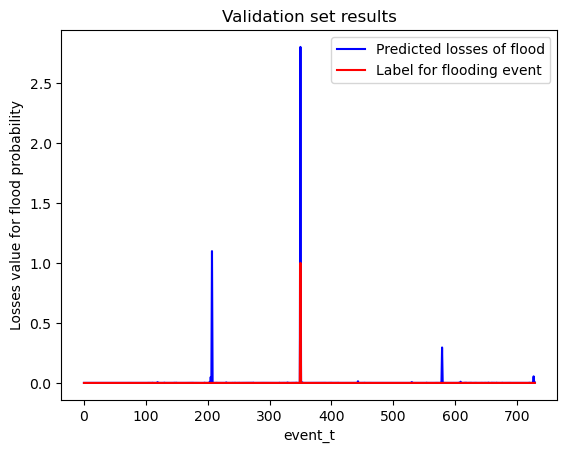

In [34]:
event_id = 0
x = np.arange(len(losses[event_id,:]))
plt.title('Validation set results')
plt.plot(x,losses[event_id,:], label='Predicted losses of flood', color='blue')
plt.plot(x,valid_labels[event_id,:], label='Label for flooding event',color='red')
plt.ylabel('Losses value for flood probability')
plt.xlabel('event_t')
plt.legend()
plt.show()

To run on the test set it is enough to call `get_prediction` function which applies the model given a set of inputs.

In [35]:
# Logits for the test set
_, _, test_ds = get_datasets()
test_inputs = (test_ds['timeseries'], test_ds['image'])
_, logits = get_prediction(final_state, test_inputs,is_training=False,)

This plot contains the same information as the blue curve of the previous one, only this time you do not have the labels, as these are the values you need to submit to Zindi.

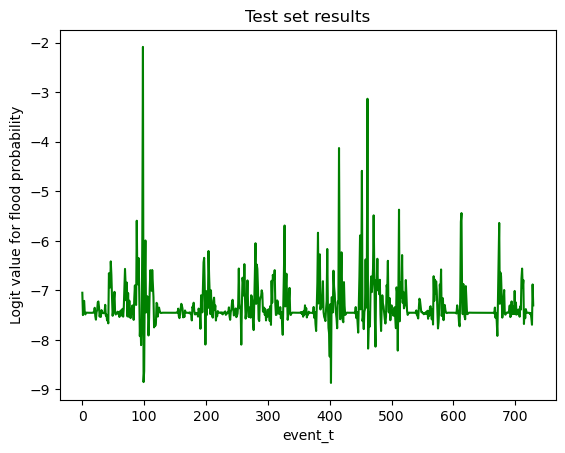

In [36]:
plt.plot(x,logits[event_id,:], color='green')
plt.ylabel('Logit value for flood probability')
plt.title('Test set results')
plt.xlabel('event_t')
plt.show()

### Prepare submission file for scoring

In [37]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

probs = sigmoid(logits)
probs.shape

(224, 730)

In [38]:
sample_submission = pd.read_csv(BASE_PATH + '/SampleSubmission.csv')
sample_submission['label'] = probs.flatten()
sample_submission.head()

,event_id,label
0,id_j7b6sokflo4k_X_0,0.000868
1,id_j7b6sokflo4k_X_1,0.000553
2,id_j7b6sokflo4k_X_2,0.000721
3,id_j7b6sokflo4k_X_3,0.000737
4,id_j7b6sokflo4k_X_4,0.000568


In [30]:
sample_submission.to_csv('BenchmarkSubmission.csv', index = False)

**Good luck!**